In [20]:
# Typical Python services scale with worker processes
# The main vulnerability is when those workers are blocking
# on downstream services, which causes queueing on your
# service.

# How many workers you run available for requests
num_workers = 40

# How many requests you can service per worker. Typically with
# Python services this is 1 (unless gevent)
requests_per_worker = 1

# How much QPS you expect your service to take
# typical and maximum
typical_qps, max_qps = 100, 200

assert typical_qps <= max_qps

# How fast on average your service responds in seconds
# If you don't know this, take a guess. It's not
# really used by the analysis but is plotted as a reference
typical_response_time_s = 0.100

# services that your service calls
# we care about worst case latency to these services
# because when those services get slow your Python workers block
# A good value is your load balancer or otherwise enforced timeout
#
# (name, **worst** case latency (s), QPS)
downstream_services = [
    ('database', 1, typical_qps),
    ('svc', 0.2, typical_qps / 2.0)
]


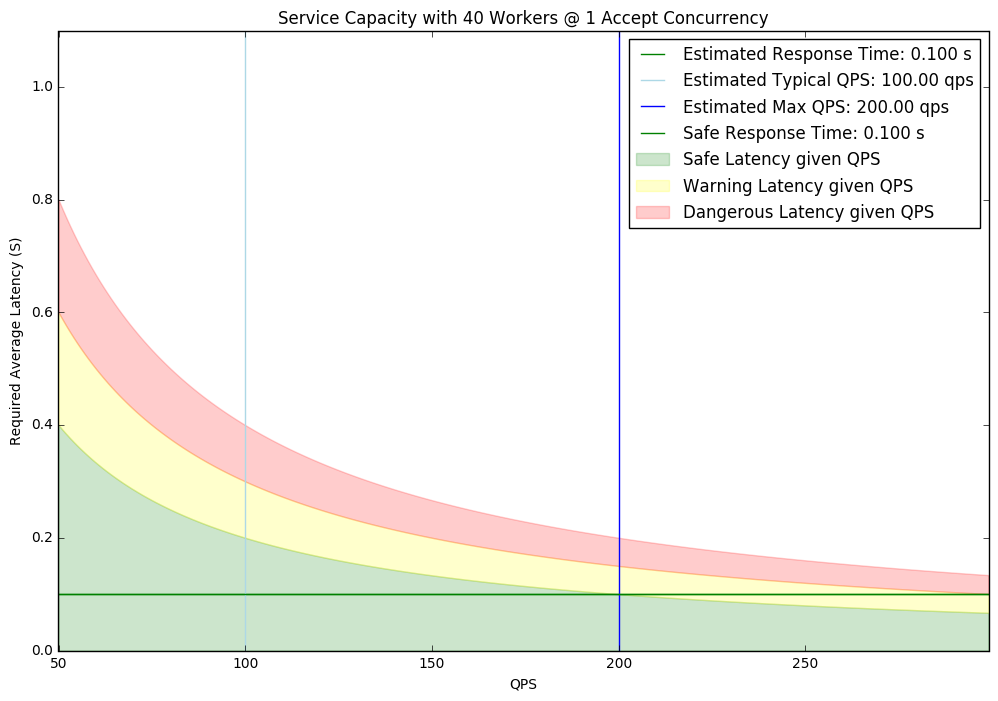

In [21]:
import random

import matplotlib.pyplot as plt
import numpy as np

# Model performance tradeoff
effective_workers = num_workers * requests_per_worker

safe_workers = 0.5 * effective_workers
danger_workers = 0.75 * effective_workers
all_workers = 1.0 * effective_workers

QPS = np.arange(max(1, int(typical_qps * 0.5)), int(max_qps * 1.50), 1) 

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title(
    'Service Capacity with {0} Workers @ {1} Accept Concurrency'.format(
        num_workers, requests_per_worker
    )
)

safe_response_time = safe_workers / max_qps
if safe_response_time >= typical_response_time_s:
    trt_c = 'green'
else:
    trt_c = 'red'
    
ax.axhline(
    y=typical_response_time_s, color=trt_c,
    label='Estimated Response Time: {0:.3f} s'.format(typical_response_time_s)
)
ax.axvline(
    x=typical_qps, color='lightblue',
    label='Estimated Typical QPS: {0:.2f} qps'.format(typical_qps)
)
ax.axvline(
    x=max_qps,
    label='Estimated Max QPS: {0:.2f} qps'.format(max_qps)
)
ax.axhline(
    y=safe_response_time, color='green',
    label='Safe Response Time: {0:.3f} s'.format(safe_response_time)
)
    
# Littles Law: queue size = avg qps * latency in s
# Show Different Latency Zones
green = [safe_workers / qps for qps in QPS]
red = [danger_workers / qps for qps in QPS]
total = [all_workers / qps for qps in QPS]

ax.fill_between(
    QPS, 0, green, interpolate=True, color='green', alpha=0.2,
    label='Safe Latency given QPS'
)
ax.fill_between(
    QPS, green, red, interpolate=True, color='yellow', alpha=0.2,
    label='Warning Latency given QPS'
)
ax.fill_between(
    QPS, red, total, interpolate=True, color='red', alpha=0.2,
    label='Dangerous Latency given QPS'
)

ax.set_ylim([0, max(typical_response_time_s * 10, safe_response_time + 1)])
ax.set_xlim([min(QPS), max(QPS)])

ax.set_xlabel('QPS')
ax.set_ylabel('Required Average Latency (S)')
plt.legend(loc='upper right')

if safe_response_time < typical_response_time_s:
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    better_worker_count = (
        (max_qps * typical_response_time_s * 2) / requests_per_worker
    )
    msg = (
        'Service overloaded!!\n'
        'Estimated latency of {0}ms and\n'
        'Estimated max QPS of {1}qps requires:\n'
        '{2:0.2f} workers, not {3}'
    ).format(typical_response_time_s, max_qps, better_worker_count, num_workers)
    ax.text(0.05, 0.95, msg, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


plt.show()

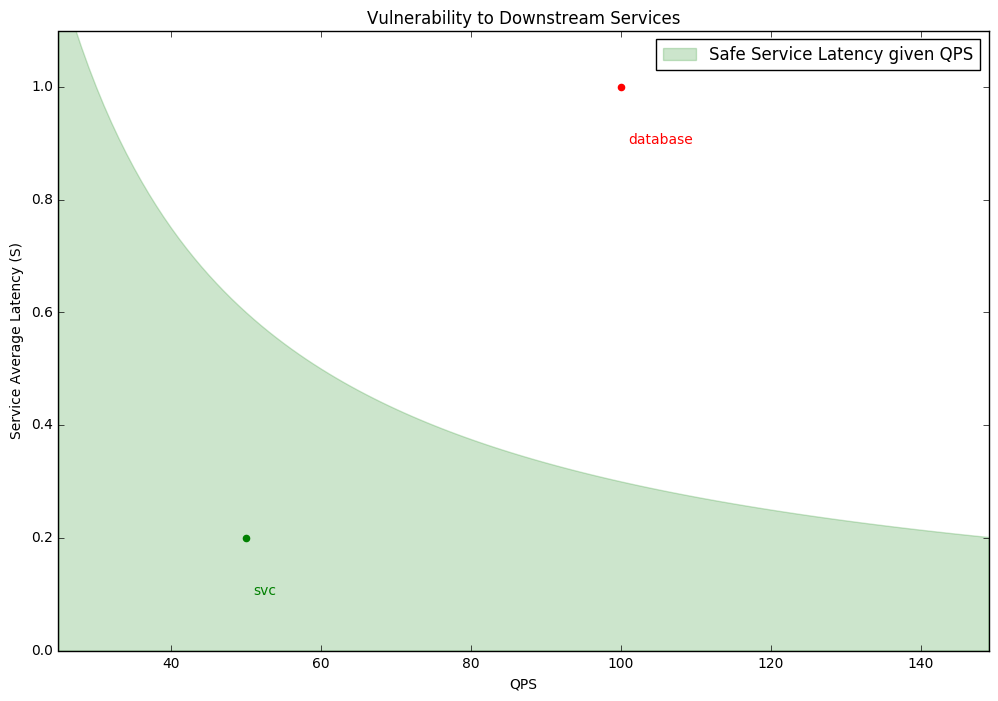

In [22]:
# Slow downstream modeling

typical_workers = typical_qps * typical_response_time_s
spare = effective_workers - typical_workers

min_svc_qps = min(d[2] for d in downstream_services)
max_svc_qps = max(d[2] for d in downstream_services)

svc_QPS = np.arange(max(1, int(min_svc_qps * 0.5)), int(max_svc_qps * 1.50), 1) 

svc_latency = [spare / qps for qps in svc_QPS]

good = {
    'x': [],
    'y': [],
    'labels': [],
    'color': 'green'
}
bad = {
    'x': [],
    'y': [],
    'labels': [],
    'color': 'red'
}

for s in downstream_services:
    d = {}
    if s[1] < (spare / s[2]):
        d = good
    else:
        d = bad
    d['x'].append(s[2])
    d['y'].append(s[1])
    d['labels'].append(s[0])


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Vulnerability to Downstream Services')

for dat in (good, bad):
    ax.scatter(dat['x'], dat['y'], color=dat['color'], picker=True)
    for i, txt in enumerate(dat['labels']):
        xy = (dat['x'][i], dat['y'][i])
        xytext = (xy[0] + 1, xy[1] - (hash(txt) % 2) / 10.0)
        ax.annotate(txt, xy=xy, xytext=xytext,color=dat['color'])
    
zero = np.zeros(len(svc_latency))
ax.fill_between(
    svc_QPS, zero, svc_latency, interpolate=True, color='green', alpha=0.2,
    label='Safe Service Latency given QPS'
)
ax.set_ylim([0, max(typical_response_time_s * 10, safe_response_time + 1)])
ax.set_xlim([min(svc_QPS), max(svc_QPS)])

ax.set_xlabel('QPS')
ax.set_ylabel('Service Average Latency (S)')
plt.legend(loc='upper right')

plt.show()